In [2]:
# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.

from jupyter_dash import JupyterDash
from dash import Dash, html, dcc, Input, Output, callback , State, ctx, dash_table
import plotly.express as px
import pandas as pd

import numpy as np
import pandas as pd
import plotly
from plotly.subplots import make_subplots

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go
import sqlite3
import datetime as dt
from datetime import date
from datetime import datetime
import dateutil.relativedelta

import requests
from bs4 import BeautifulSoup

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

app = JupyterDash(__name__)

index = ''

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options

def stock_info(ticker):
    con = sqlite3.connect("stock.sqlite")
    cur = con.cursor()
    data = pd.read_sql("SELECT * FROM stock_info where Ticker = '"+ticker+"';",con)
    data = data.drop(columns=['Ticker'])
    return data

def table_finance(ticker):
    con = sqlite3.connect("stock.sqlite")
    cur = con.cursor()
    data = pd.read_sql("SELECT * FROM stock_financial where Ticker = '"+ticker+"';",con)
    column = data['Year'].values.tolist()
    data = data.transpose()
    data.columns = column
    data = data.drop("Ticker")
    data = data.drop("Year")
    head = data.index.values.tolist()
    data.insert(0, "Financial Information", head, True)
    return data

def table_quarterly(ticker):
    con = sqlite3.connect("stock.sqlite")
    cur = con.cursor()
    data = pd.read_sql("SELECT * FROM stock_quarter where Ticker = '"+ticker+"';",con)
    data = data.drop(columns=['Ticker'])
    column = data['Quarterly'].values.tolist()
    data = data.transpose()
    data.columns = column
    data = data.drop("Quarterly")
    head = data.index.values.tolist()
    data.insert(0, "Quarterly", head, True)
    return data

def table_news(ticker):
    con = sqlite3.connect("stock.sqlite")
    cur = con.cursor()
    data = pd.read_sql("SELECT * FROM stock_news where Ticker = '"+ticker+"' order by Datetime desc;",con)
    data = data.drop(columns=['Ticker'])
    return data



def plot(ticker, interval):
    now = dt.datetime.now()
    last_month = now + dateutil.relativedelta.relativedelta(months=-1)
    seven_month = now + dateutil.relativedelta.relativedelta(months=-7)
    ten_year = now + dateutil.relativedelta.relativedelta(years=-10)
    conn = sqlite3.connect("stock.sqlite")
    cur = conn.cursor()
    query1 = "SELECT * FROM stock_table_hr WHERE `ticker` == '%s' AND datetime > '%s' AND datetime < '%s'" % (ticker, last_month, now)
    query2 = "SELECT * FROM stock_table_d WHERE `ticker` == '%s' AND datetime > '%s' AND datetime < '%s'" % (ticker, seven_month, now)
    query3 = "SELECT * FROM stock_table_mo WHERE `ticker` == '%s' AND datetime > '%s' AND datetime < '%s'" % (ticker, ten_year, now)
    Hr = pd.read_sql(query1,conn)
    Day = pd.read_sql(query2,conn)
    Mo = pd.read_sql(query3,conn)
    #declare figure
    fig = go.Figure()
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                vertical_spacing=0.1, subplot_titles=('OHLC', 'Volume','MACD'), 
                row_width=[0.2, 0.7, 0.7])

    #Candlestick

    # fig.update_xaxes( rangebreaks=[ dict(values = timegap_hr , dvalue = 3600000)])
    if interval == "Hour":
        Hr['time'] = pd.to_datetime(Hr['Datetime'])
        Hr['MA50'] = Hr['Close'].rolling(window = 50 , min_periods = 0).mean()
        Hr['MA200'] = Hr['Close'].rolling(window = 200 , min_periods = 0).mean()
        Hr['EMA12'] = Hr['Close'].ewm(span=12, adjust=False, min_periods = 0).mean()
        Hr['EMA26'] = Hr['Close'].ewm(span=26, adjust=False, min_periods = 0).mean()
        Hr.set_index(Hr['time'],inplace = True)
        macd = Hr['EMA12'] - Hr['EMA26']
        signal = macd.ewm(span=9, adjust=False).mean()
        fig.add_trace(go.Candlestick(x=Hr.Datetime,
                        open=Hr.Open,
                        high=Hr.High,
                        low=Hr.Low,
                        close=Hr.Close, 
                        name = ticker,),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'MA50',x=Hr.Datetime,y=Hr['MA50']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'MA200',x=Hr.Datetime,y=Hr['MA200']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'EMA12',x=Hr.Datetime,y=Hr['EMA12']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'EMA26',x=Hr.Datetime,y=Hr['EMA26']),row=1, col=1)
        fig.add_trace(go.Bar(x=Hr.Datetime, y=Hr.Volume,showlegend=False), row=2, col=1)
        fig.add_trace(go.Bar(name = 'MACD',x=Hr.Datetime,y=signal),row=3, col=1)

        df_resample_hr = Hr.resample('H').max()
        merged_index_hr  = Hr.index.append(df_resample_hr.index)
        timegap_hr = merged_index_hr[~merged_index_hr.duplicated(keep = False)]

        fig.update_xaxes(rangebreaks=[dict(values=timegap_hr, dvalue=3600000)])
        
    elif interval == "Day":
        Day['time'] = pd.to_datetime(Day['Datetime'])
        Day['MA50'] = Day['Close'].rolling(window = 50 , min_periods = 0).mean()
        Day['MA200'] = Day['Close'].rolling(window = 200 , min_periods = 0).mean()
        Day['EMA12'] = Day['Close'].ewm(span=12, adjust=False, min_periods = 0).mean()
        Day['EMA26'] = Day['Close'].ewm(span=26, adjust=False, min_periods = 0).mean()
        macd = Day['EMA12'] - Day['EMA26']
        signal = macd.ewm(span=9, adjust=False).mean()
        Day.set_index(Day['time'],inplace = True)
        fig.add_trace(go.Candlestick(x=Day.Datetime,
                        open=Day.Open,
                        high=Day.High,
                        low=Day.Low,
                        close=Day.Close, 
                        name = ticker,),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'MA50',x=Day.Datetime,y=Day['MA50']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'MA200',x=Day.Datetime,y=Day['MA200']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'EMA12',x=Day.Datetime,y=Day['EMA12']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'EMA26',x=Day.Datetime,y=Day['EMA26']),row=1, col=1)
        fig.add_trace(go.Bar(x=Day.Datetime, y=Day.Volume,showlegend=False), row=2, col=1)
        fig.add_trace(go.Bar(name = 'MACD',x=Day.Datetime,y=signal),row=3, col=1)

    
        df_resample_day = Day.resample('D').max()
        merged_index_day  = Day.index.append(df_resample_day.index)
        timegap_day = merged_index_day[~merged_index_day.duplicated(keep = False)]
        fig.update_xaxes(rangebreaks=[dict(values=timegap_day)])

    elif interval == "Month":
        Mo['time'] = pd.to_datetime(Mo['Datetime'])
        Mo['MA50'] = Mo['Close'].rolling(window = 50 , min_periods = 0).mean()
        Mo['MA200'] = Mo['Close'].rolling(window = 200 , min_periods = 0).mean()
        Mo['EMA12'] = Mo['Close'].ewm(span=12, adjust=False, min_periods = 0).mean()
        Mo['EMA26'] = Mo['Close'].ewm(span=26, adjust=False, min_periods = 0).mean()
        Mo.set_index(Mo['time'],inplace = True)
        macd = Mo['EMA12'] - Mo['EMA26']
        signal = macd.ewm(span=9, adjust=False).mean()
        fig.add_trace(go.Candlestick(x=Mo.Datetime,
                        open=Mo.Open,
                        high=Mo.High,
                        low=Mo.Low,
                        close=Mo.Close, 
                        name = ticker,),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'MA50',x=Mo.Datetime,y=Mo['MA50']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'MA200',x=Mo.Datetime,y=Mo['MA200']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'EMA12',x=Mo.Datetime,y=Mo['EMA12']),row=1, col=1)
        fig.add_trace(go.Scatter(name = 'EMA26',x=Mo.Datetime,y=Mo['EMA26']),row=1, col=1)
        fig.add_trace(go.Bar(x=Mo.Datetime, y=Mo.Volume,showlegend=False), row=2, col=1)
        fig.add_trace(go.Bar(name = 'MACD',x=Mo.Datetime,y=signal),row=3, col=1)

    fig.update_xaxes(rangemode="nonnegative")
    fig.update_yaxes(fixedrange=False)
    fig.update_layout(hovermode = "x")
    fig.update(layout_xaxis_rangeslider_visible=False)
    return fig

def getLastDate(period,ticker):
    conn = sqlite3.connect("stock.sqlite")
    cur = conn.cursor()
    # Query last element of stock in database
    if period == 'Hour':
        query = "SELECT * FROM stock_table_hr WHERE `ticker` = '%s'" % ticker
    elif period == 'Day':
        query = "SELECT * FROM stock_table_d WHERE `ticker` = '%s'" % ticker
    elif period == 'Month':
        query = "SELECT * FROM stock_table_mo WHERE `ticker` = '%s'" % ticker
    else:
        return False
    r_df = pd.read_sql(query, conn)
    # Cut data to get only datatime
    last = r_df.tail(1).Datetime.to_string().split()
    LastDate = last[1].split()[0].split('-')
    cur.close()
    return LastDate,r_df


def getDiffDay(period,ticker):
    LastDate,r_df = getLastDate(period,ticker)
    if LastDate == False:
        return False
    # Get datetime for now
    x = datetime.datetime.now()
    count = 0
    DayM = 0
    DayMo365 = {'1':31,'2':28,'3':31,'4':30,'5':31,'6':30,'7':31,'8':31,'9':30,'10':31,'11':30,'12':31}
    DiffMo = int(x.month) - int(LastDate[1])
    DiffYe = int(x.year) - int(LastDate[0])
    # Get differend day for dowload stock
    if DiffYe == 0:
        if DiffMo == 0:
            DiffDay = int(x.day) - int(LastDate[2])
            if DiffDay != 0:pass
        elif DiffMo != 0 :
            for u in range(DiffMo):
                DayM = DayM + DayMo365[str(int(LastDate[1])+count)]
                count += 1
            DiffDay = DayM - int(LastDate[2]) + int(x.day)
    elif DiffYe != 0:
        dayly = 0
        dayn = 0
        for j in range(1,int(LastDate[1])):
            dayly = dayly + DayMo365[str(j)]
        for i in range(1,int(x.month)):
            dayn = dayn + DayMo365[str(i)]
        DiffDay = (365*DiffYe) - dayly + dayn - int(LastDate[2]) + int(x.day)   
    DiffDay = str(DiffDay) + 'd'
    return DiffDay

    
def update(period, ticker):
    LastDate,r_df = getLastDate(period,ticker)
    DiffDay = getDiffDay(period,ticker)
    count = 0
    conn = sqlite3.connect("stock.sqlite")
    # Select period to download
    if period == 'Hour':data = yf.download(tickers=ticker, period=DiffDay, interval='1h',progress=False)
    elif period == 'Day':data = yf.download(tickers=ticker, period=DiffDay, interval='1d',progress=False)
    elif period == 'Month':data = yf.download(tickers=ticker, period=DiffDay, interval='1mo',progress=False)
    # Get number of extra stock
    for i in data.index.day:
        if data.index.year[count] == int(LastDate[0]):
            if data.index.month[count] == int(LastDate[1]):
                if period == 'Month':
                    if i == int(LastDate[2])+1 or i == int(LastDate[2])+2 or i == int(LastDate[2])+3 or i == int(LastDate[2]):
                        break
                else:
                    if i == int(LastDate[2])+1 or i == int(LastDate[2])+2 or i == int(LastDate[2])+3:
                        break
        count += 1
    # Cut extra stock off
    down = check_stock(period, ticker)
    count = count - down
    data['ticker'] = ticker
    data = data.iloc[count:,:]
    data.index.names = ['Datetime']
    # Select period to download and Save to sqlite
    if period == 'Hour':data.to_sql('stock_table_hr',con=conn,if_exists='append',index=True)
    elif period == 'Day':data.to_sql('stock_table_d',con=conn,if_exists='append',index=True)
    elif period == 'Month':data.to_sql('stock_table_mo',con=conn,if_exists='append',index=True)
    print(data)
    return data

def check_stock(period, ticker):
    LastDate,r_df = getLastDate(period,ticker)
    DiffDay = getDiffDay(period,ticker)
    conn = sqlite3.connect("stock.sqlite")
    down = 0
    query = "SELECT `Index` FROM stock_info WHERE `ticker` = '%s'" % ticker
    for_ind = pd.read_sql(query, conn)
    ok = r_df.tail(1).Datetime.to_string().split()[2]
    #for get extra time in database
    if for_ind['Index'].values == 'NASDAQ100':
        DiffDay = str(DiffDay)+'d'
        if ok == '09:30:00':down = 6
        elif ok == '10:30:00':down = 5
        elif ok == '11:30:00':down = 4
        elif ok == '12:30:00':down = 3
        elif ok == '13:30:00':down = 2
        elif ok == '14:30:00':down = 1
        elif ok == '15:30:00':down = 0
    elif for_ind['Index'].values == 'SET100':
        DiffDay = str(DiffDay)+'d'
        if ok == '10:00:00':down = 5
        elif ok == '11:00:00':down = 4
        elif ok == '12:00:00':down = 3
        elif ok == '14:00:00':down = 2
        elif ok == '15:00:00':down = 1
        elif ok == '16:00:00':down = 0
    elif for_ind['Index'].values == 'CRYPTO100':
        DiffDay = str(DiffDay+1)+'d'
        if ok == '00:00:00':down = 23
        elif ok == '01:00:00':down = 22
        elif ok == '02:00:00':down = 21
        elif ok == '03:00:00':down = 20
        elif ok == '04:00:00':down = 19
        elif ok == '05:00:00':down = 18
        elif ok == '06:00:00':down = 17
        elif ok == '07:00:00':down = 16
        elif ok == '08:00:00':down = 15
        elif ok == '09:00:00':down = 14
        elif ok == '10:00:00':down = 13
        elif ok == '11:00:00':down = 12
        elif ok == '12:00:00':down = 11
        elif ok == '13:00:00':down = 10
        elif ok == '14:00:00':down = 9
        elif ok == '15:00:00':down = 8
        elif ok == '16:00:00':down = 7
        elif ok == '17:00:00':down = 6
        elif ok == '18:00:00':down = 5
        elif ok == '19:00:00':down = 4
        elif ok == '20:00:00':down = 3
        elif ok == '21:00:00':down = 2
        elif ok == '22:00:00':down = 1
        elif ok == '23:00:00':down = 0
    return down
        
def stock_name():
    conn = sqlite3.connect("stock.sqlite")
    cur = conn.cursor()
    query = "select distinct Ticker from stock_table_hr"
    r_df = pd.read_sql(query,conn)
    list_db = r_df['Ticker'].values.tolist()
    return list_db

def download_ticker(period,ticker):
        conn = sqlite3.connect("stock.sqlite")
        cur = conn.cursor()
        try:
            # Select period to download
            if period == 'Hour':
                data = yf.download(tickers=ticker, period='2y', interval='1h',progress=False)
            elif period == 'Day':
                data = yf.download(tickers=ticker, period='max', interval='1d',progress=False)
            elif period == 'Month':
                data = yf.download(tickers=ticker, period='max', interval='1mo',progress=False)
            else:
                data = []
            # Save to sqlite3
            #data.to_sql('stock_table',con=conn,if_exists='append',index=True)
            # return data to ploting graph
            if data.empty:
                raise ValueError
            return data
        except:
            return []

def list_set():
    set = []
    conn = sqlite3.connect("stock.sqlite")
    cur = conn.cursor()
    query = "select Ticker from stock_info where `Index` == 'SET100'"
    stock = pd.read_sql(query,conn)
    stock = list(stock['Ticker'])
    for i in stock:
        temp = i.split('.')
        set.append(temp[0])
    return set

def list_nasdaq():
    conn = sqlite3.connect("stock.sqlite")
    cur = conn.cursor()
    query = "select Ticker from stock_info where `Index` == 'NASDAQ100'"
    stock = pd.read_sql(query,conn)
    stock = list(stock['Ticker'])
    return stock

def list_crypto():
    crypto = []
    conn = sqlite3.connect("stock.sqlite")
    cur = conn.cursor()
    query = "select Ticker from stock_info where `Index` == 'CRYPTO100'"
    stock = pd.read_sql(query,conn)
    stock = list(stock['Ticker'])
    for i in stock:
        temp = i.split('-')
        crypto.append(temp[0])
    return crypto

def save_data_news(data):
        # connect to the database
        conn = sqlite3.connect('stock.sqlite')
        # save the data to the database
        data.to_sql('stock_news',con=conn,if_exists='append',index=False)
        

def load_data_news(date, title, url, ticker):
        # connect to the database
        conn = sqlite3.connect('stock.sqlite')
        cur = conn.cursor()
        query = "SELECT * FROM stock_news WHERE DATETIME = ? AND Title = ? AND Link = ? AND Ticker = ?" 
        cur.execute(query, (date, title, url, ticker))
        data = cur.fetchall()
        return data

def find_link(link):
    all_link = []
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'lxml')
    data = soup.find_all(class_="tie-col-md-11 tie-col-sm-10 tie-col-xs-10")
    
    if data == []:
        return False

    for i in data:
        href = i.find('a').get('href')
        all_link.append(href)
    return all_link
     

def scrap_news_SET(link ,stock):
    all_link = find_link(link)

    for i in all_link:
        try:
            url = i
            response = requests.get(url)
            soup = BeautifulSoup(response.content, 'lxml')
            get_url = response.url
            title = soup.find(class_="post-title entry-title")
            date = soup.find(class_="date meta-item tie-icon")
            body = soup.find(class_="entry-content entry clearfix")
            tag = soup.find_all(rel="tag")

            date = date.text.split("/")
            date.reverse()
            if int(date[0]) < 2019:
                return False
            date = "-".join(date)
            date_format = "%Y-%m-%d"
            date_obj = datetime.strptime(date, date_format)

            body = body.text.split("\n")
            body = " ".join(body)

            for ticker in tag:
                if ticker.text in stock:
                    ticker = ticker.text + '.BK'
                    news =  load_data_news(date_obj, title.text, get_url, ticker)
                    print(news)
                    if news != []:
                            return False
                    else:
                        df = pd.DataFrame({'Datetime': [date_obj], 'Title':[title.text], 'Link':[get_url], 'Body':[body], 'Ticker':[ticker]})
                        print(df)
                        save_data_news(df)              
        except:
            pass
    return True

def next_page_scrap(stock):
    try:
        num = 1
        case = True
        while case == True:
            num += 1
            run = scrap_news_SET('https://www.kaohoon.com/latest-news/page/'+str(num), stock)
            if run == False:
                return 'Stop'
    except:
        return 'Error'
        
def News_SET100():
    stock = list_set()
    work = True
    while work == True:
        try:
            scrap_news_SET('https://www.kaohoon.com/latest-news', stock)
            re = next_page_scrap(stock)
            if re == 'Stop':
                work = False
        except Exception as e: 
            print(e)
    return True

def news_Nasdaq(interger):
    nasdaq = list_nasdaq()
    con = sqlite3.connect("stock.sqlite")
    cur = con.cursor()
    try:
        for i in nasdaq[interger:]:
            ind = nasdaq.index(i)
            url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers='+ i +'&limit=200&apikey=8X8QE27D001F3TV'
            r = requests.get(url)
            data = r.json()
            round = int(data['items'])
            for j in range(round):
                print(j)
                title = data['feed'][j]['title']
                date = data['feed'][j]['time_published']
                get_url = data['feed'][j]['url']
                body = data['feed'][j]['summary']

                date = date.split("T")
                date = date[0]
                year = date[:4]
                mo = date[4:6]
                day = date[6:]

                date = [year,mo,day]
                date = "-".join(date)
                date_format = "%Y-%m-%d"
                date_obj = datetime.strptime(date, date_format)

                query = "SELECT * FROM stock_news WHERE DATETIME = ? AND Title = ? AND Link = ? AND Ticker = ?"
                cur.execute(query, (date_obj, title, get_url, i))
                news = cur.fetchall()
                print(news)
                if news != []:
                    break
                else:
                    df = pd.DataFrame({'Datetime': [date_obj], 'Title':[title], 'Link':[get_url], 'Body':[body], 'Ticker':[i]})
                    print(df)
                    save_data_news(df)
    except: 
        news_Nasdaq(ind)

def news_Crypto(interger):
    crypt = list_crypto()
    con = sqlite3.connect("stock.sqlite")
    cur = con.cursor()
    try:
        for i in crypt[interger:]:
            print(i)
            ind = crypt.index(i)
            cryp = i.split('-')
            cryp = cryp[0]
            # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
            url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&blockchain='+ cryp +'&limit=200&apikey=8X8QE27D001F3TV'
            r = requests.get(url)
            data = r.json()
            round = int(data['items'])
            for j in range(round):
                print(j)
                title = data['feed'][j]['title']
                date = data['feed'][j]['time_published']
                get_url = data['feed'][j]['url']
                body = data['feed'][j]['summary']
                date = date.split("T")
                date = date[0]
                year = date[:4]
                mo = date[4:6]
                day = date[6:]
                date = [year,mo,day]
                date = "-".join(date)
                date_format = "%Y-%m-%d"
                date_obj = datetime.strptime(date, date_format)

                query = "SELECT * FROM stock_news WHERE DATETIME = ? AND Title = ? AND Link = ? AND Ticker = ?"
                cur.execute(query, (date_obj, title, get_url, i))
                news = cur.fetchall()
                print(news)
                if news != []:
                    break
                else:
                    df = pd.DataFrame({'Datetime': [date_obj], 'Title':[title], 'Link':[get_url], 'Body':[body], 'Ticker':[i]})
                    print(df)
                    save_data_news(df)
    except : 
        news_Crypto(ind)

def plot_spatial(ticker):
    conn = sqlite3.connect("stock.sqlite")
    query = "SELECT city,lat,long FROM stock_city WHERE `Ticker` = '%s'" % ticker
    address = pd.read_sql(query, conn)
    add = address.groupby(address.columns.tolist(),as_index=False).size()
    add.rename(columns={'size': 'population'}, inplace=True)
    df = add

    fig = px.scatter_mapbox(df, lat="lat", lon="long", hover_name="city", size="population",
                            color_continuous_scale="reds", zoom=3, height=600)
    fig.update_layout(mapbox_style="carto-positron")
    return fig



######DASH######
app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    html.Div(id='page-content',),
])


@app.callback([Output('graph','style'),Output('popup', 'displayed')],
              [Input('submit-button', 'n_clicks')],
              [State('ticker-input', 'value')])

def update_popup_and_graph(n_clicks, value):
    list_db = stock_name()
    value = value.upper()
    if n_clicks:
        if value.strip() == '' or (value.strip() not in list_db):
            return plot('','Hour'),True
        else:
            return plot(value, 'Hour'),False
    return plot('', 'Hour'),False

#return graph from ticker input
@app.callback(Output('graph','figure'),
              [Input('stock-dropdown', 'value'), 
              Input('submit-button', 'n_clicks')],
              [State('ticker-input', 'value')],)
def update_graph(stock_dropdown, submit_clicks, ticker_input):
    global index
    global df 
    df = table_finance(index)
    if stock_dropdown != None:
        return dropdown_output(stock_dropdown, ticker_input.upper())
    elif submit_clicks is not None:
        index = ticker_input
        return update_output(ticker_input.upper())   

def update_output(ticker_input):
    list_db = stock_name()
    value = ticker_input.upper()
    if value.strip() == '' or (value.strip() not in list_db):
            fig = plot('','Hour')
            return fig
    else:
        for i in ['Hour','Day','Month']:
            update(i,value)
        value = value.upper()
        fig = plot(value,'')
        return fig

def dropdown_output(stock_dropdown ,ticker_input):
    global dropdown_value
    dropdown_value = stock_dropdown
    value = str(ticker_input).upper()
    fig = plot(value, stock_dropdown)
    return fig


#
@app.callback(
    [Output("popup_dl", "displayed"),Output("popup_fa", "displayed")],
    [Input("popup", "submit_n_clicks")],
    [State('ticker-input', 'value')]
)
def execute_function(submit_n_clicks ,value):
    data = download_ticker('Hour',value)
    if submit_n_clicks and data != []:
        return True,False
    elif submit_n_clicks and data == []:
        return False,True
    return False,False

# reset value dropdown
@app.callback(Output('stock-dropdown', 'value'),
              Output("disp-ticker", "children"),
              [Input('submit-button', 'n_clicks')],
              [State('ticker-input', 'value')]
             )
def reset_dropdown(n_clicks, value):
    return None, value.upper()

#show table when press button
@app.callback(
    Output('disp-info', 'children'),
    [Input('submit-button', 'n_clicks')],
    [State('ticker-input', 'value')]
)
def show_table(submit_clicks, ticker_input):
    global index
    global df 
    if submit_clicks is not None:
        index = ticker_input.upper()
        df = stock_info(index)
        return dash_table.DataTable(df.to_dict('records'), [{"name": i, "id": i} for i in df.columns],
            id='table-financial',
            style_cell={
                'whiteSpace': 'normal',
                'height': 'auto'},
                fill_width=False
        )

#show table finance when press button
@app.callback(
    Output('table-container-home', 'children'),
    [Input('submit-button', 'n_clicks')],
    [State('ticker-input', 'value')]
)
def show_table(submit_clicks, ticker_input):
    global index
    global df 
    if submit_clicks is not None:
        index = ticker_input.upper()
        df = table_finance(index)
        return dash_table.DataTable(df.to_dict('records'), [{"name": i, "id": i} for i in df.columns],
            id='table-financial',
            style_cell={
                'whiteSpace': 'normal',
                'height': 'auto'},
                fill_width=False
        )


#show table finance when press button
@app.callback(
    Output('table-container', 'children'),
    [Input('finance-dropdown', 'value'),
    Input('submit-button', 'n_clicks')],
    [State('ticker-input', 'value')]
)
def show_table(stock_dropdown, submit_clicks, ticker_input):
    global index
    global df 
    if submit_clicks is not None:
        index = ticker_input.upper()
        if stock_dropdown == 'Annual':
            df = table_finance(index)
            return dash_table.DataTable(df.to_dict('records'), [{"name": i, "id": i} for i in df.columns],
                id='table-financial',
                style_cell={
                    'whiteSpace': 'normal',
                    'height': 'auto'},
                    fill_width=False
            )
        elif stock_dropdown == 'Quarterly':
            df = table_quarterly(index)
            return dash_table.DataTable(df.to_dict('records'), [{"name": i, "id": i} for i in df.columns],
                id='table-financial',
                style_cell={
                    'whiteSpace': 'normal',
                    'height': 'auto'},
                    fill_width=False
            )

#show table news when press button
@app.callback(
    Output('news-container', 'children'),
    [Input('submit-button', 'n_clicks')],
    [State('ticker-input', 'value')]
)
def show_table(submit_clicks, ticker_input):
    global index
    global df 
    if submit_clicks is not None:
        index = ticker_input.upper()
        df = update_news(index)
        return dash_table.DataTable(df.to_dict('records'), [{"name": i, "id": i} for i in df.columns],
            id='news-financial',
            style_cell={
                'whiteSpace': 'normal',
                'height': 'auto'},
                fill_width=False
        )
    
def update_news(ticker_input):
    set = list_set()
    nasdaq = list_nasdaq()
    crypto = list_crypto()
    ticker_input = ticker_input.split(".")
    ticker_input = ticker_input[0]
    print(ticker_input,set)
    print(ticker_input, nasdaq)
    print(crypto)
    if ticker_input in set:
        News_SET100()
    elif ticker_input in nasdaq:
        news_Nasdaq(0)
    elif ticker_input in crypto:
        news_Crypto(0)
    return table_news(index)

# Update the index
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/graph':
        return html.Div(children=[
                    html.Div([
                        html.Div([
                            "Stock : ",
                            dcc.Input(id='ticker-input', value=index, type='text'),
                            html.Button(id='submit-button', n_clicks=0, children='Submit'),
                        ],
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        dcc.Dropdown(['Hour', 'Day', 'Month'],
                            searchable=False,
                            id='stock-dropdown',
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        html.Div(id='output-div'),
                        html.Div(id="disp-ticker"),
                        ],
                        style={
                            'margin-top' : 50,
                            'margin-right': 100,
                            'margin-left': 100
                        }
                    ),
                    html.Div([
                        dcc.Graph(
                            id='graph',
                            figure=plot('','Hour')
                        )],
                        style={
                                'margin-right': 20,
                                'margin-left': 20
                        }
                    ),

                    dcc.ConfirmDialog(
                        id='popup',
                        message='Not found that tickers',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_dl',
                        message='Downloaded',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_fa',
                        message='False to download for this ticker',
                        displayed=False,
                    ),
                ])
    elif pathname == '/finance':
        return html.Div(children=[
                    html.Div([
                        html.Div([
                            "Stock : ",
                            dcc.Input(id='ticker-input', value=index, type='text'),
                            html.Button(id='submit-button', n_clicks=0, children='Submit'),
                        ],
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        dcc.Dropdown(options=[{'label': 'Annual', 'value': 'Annual'}, {'label': 'Quarterly', 'value': 'Quarterly'}],
    value='Annual',
    searchable=False,
                            id='finance-dropdown',
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        html.Div(id='output-div'),
                        html.Div(id="disp-ticker"),
                        ],
                        style={
                            'margin-top' : 50,
                            'margin-right': 100,
                            'margin-left': 100
                        }
                    ),

                    dcc.ConfirmDialog(
                        id='popup',
                        message='Not found that tickers',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_dl',
                        message='Downloaded',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_fa',
                        message='False to download for this ticker',
                        displayed=False,
                    ),
                    html.Div(id='table-container'),
                ])
    elif pathname == '/news':
        return html.Div(children=[
                    html.Div([
                        html.Div([
                            "Stock : ",
                            dcc.Input(id='ticker-input', value=index, type='text'),
                            html.Button(id='submit-button', n_clicks=0, children='Submit'),
                        ],
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        
                        html.Div(id='output-div'),
                        html.Div(id="disp-ticker"),
                        ],
                        style={
                            'margin-top' : 50,
                            'margin-right': 100,
                            'margin-left': 100
                        }
                    ),

                    dcc.ConfirmDialog(
                        id='popup',
                        message='Not found that tickers',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_dl',
                        message='Downloaded',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_fa',
                        message='False to download for this ticker',
                        displayed=False,
                    ),
                    html.Div(id='news-container'),
                ])
    elif pathname == '/spartial':
        return html.Div(children=[
                    html.Div([
                        html.Div([
                            "Stock : ",
                            dcc.Input(id='ticker-input', value=index, type='text'),
                            html.Button(id='submit-button', n_clicks=0, children='Submit'),
                        ],
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        dcc.Dropdown(['Hour', 'Day', 'Month'],
                            searchable=False,
                            id='stock-dropdown',
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        html.Div(id='output-div'),
                        html.Div([html.Div(id="disp-ticker"),
                                  html.Div(id="disp-info")
                        ])
                        ],
                        style={
                            'margin-top' : 50,
                            'margin-right': 100,
                            'margin-left': 100
                        }
                    ),
                    html.Div([
                        dcc.Graph(
                            id='graph-spartial',
                            figure=plot_spatial('AAV.BK')
                        )],
                        style={
                                'margin-right': 20,
                                'margin-left': 20
                        }
                    ),

                    dcc.ConfirmDialog(
                        id='popup',
                        message='Not found that tickers',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_dl',
                        message='Downloaded',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_fa',
                        message='False to download for this ticker',
                        displayed=False,
                    ),
                    html.Div(id='table-container-home'),
                ])
    else:
        return html.Div(children=[
                    html.Div([
                        html.Div([
                            "Stock : ",
                            dcc.Input(id='ticker-input', value=index, type='text'),
                            html.Button(id='submit-button', n_clicks=0, children='Submit'),
                        ],
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        dcc.Dropdown(['Hour', 'Day', 'Month'],
                            searchable=False,
                            id='stock-dropdown',
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        html.Div(id='output-div'),
                        html.Div([html.Div(id="disp-ticker"),
                                  html.Div(id="disp-info")
                        ])
                        ],
                        style={
                            'margin-top' : 50,
                            'margin-right': 100,
                            'margin-left': 100
                        }
                    ),
                    html.Div([
                        dcc.Graph(
                            id='graph',
                            figure=plot('','Hour')
                        )],
                        style={
                                'margin-right': 20,
                                'margin-left': 20
                        }
                    ),

                    dcc.ConfirmDialog(
                        id='popup',
                        message='Not found that tickers',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_dl',
                        message='Downloaded',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_fa',
                        message='False to download for this ticker',
                        displayed=False,
                    ),
                    html.Div(id='table-container-home'),
                ])
    # You could also return a 404 "URL not found" page here



app.run_server(debug=False)

Dash app running on http://127.0.0.1:8050/


In [1]:
from jupyter_dash import JupyterDash
import dash
import dash_leaflet as dl

app = JupyterDash()
app.layout = dl.Map(dl.TileLayer(), style={'width': '1000px', 'height': '500px'})

if __name__ == '__main__':
    app.run_server()

Dash app running on http://127.0.0.1:8050/


In [ ]:
 elif pathname == '/spartial':
        return html.Div(children=[
                    html.Div([
                        html.Div([
                            "Stock : ",
                            dcc.Input(id='ticker-input', value=index, type='text'),
                            html.Button(id='submit-button', n_clicks=0, children='Submit'),
                        ],
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        dcc.Dropdown(['Hour', 'Day', 'Month'],
                            searchable=False,
                            id='stock-dropdown',
                            style={
                                'margin-bottom': 20,
                            }
                        ),
                        html.Div(id='output-div'),
                        html.Div([html.Div(id="disp-ticker"),
                                  html.Div(id="disp-info")
                        ])
                        ],
                        style={
                            'margin-top' : 50,
                            'margin-right': 100,
                            'margin-left': 100
                        }
                    ),
                    html.Div([
                        dcc.Graph(
                            id='graph-spartial',
                            figure=plot_spatial('AAV.BK')
                        )],
                        style={
                                'margin-right': 20,
                                'margin-left': 20
                        }
                    ),

                    dcc.ConfirmDialog(
                        id='popup',
                        message='Not found that tickers',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_dl',
                        message='Downloaded',
                        displayed=False,
                    ),
                    dcc.ConfirmDialog(
                        id='popup_fa',
                        message='False to download for this ticker',
                        displayed=False,
                    ),
                    html.Div(id='table-container-home'),
                ])

In [6]:
from jupyter_dash import JupyterDash
import pandas as pd
import sqlite3
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

def plot_spatial(ticker):
    conn = sqlite3.connect("stock.sqlite")
    query = "SELECT city,lat,long FROM stock_city WHERE `Ticker` = '%s'" % ticker
    address = pd.read_sql(query, conn)
    add = address.groupby(address.columns.tolist(),as_index=False).size()
    add.rename(columns={'size': 'population'}, inplace=True)
    df = add

    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
    gdf = GeoDataFrame(df, geometry=geometry)   
    gdf['Size'] = gdf['population'] * 40
    #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    base = world.plot(figsize=(20, 10),color='black', edgecolor='black')
    a = gdf.plot(ax=base, marker='o', column='population', cmap = 'Reds', markersize='Size',legend=True)
    a.set_facecolor("lightslategray")

app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1("Stock Cities"),
    dcc.Input(
        id="ticker",
        type="text",
        placeholder="Enter a ticker",
        debounce=True
    ),
    html.Div(id="output-graph"),
])

@app.callback(
    Output('output-graph', 'children'),
    Input('ticker', 'value')
)
def update_graph(ticker):
    if ticker:
        plot_spatial(ticker)
        fig = px.imshow(plot_spatial(ticker))
        return dcc.Graph(figure=fig)
if __name__ == "__main__":
    app.run_server(debug=True)


C:\Users\Best\AppData\Local\Temp\ipykernel_22868\533700425.py:8: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\Best\AppData\Local\Temp\ipykernel_22868\533700425.py:9: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



Dash app running on http://127.0.0.1:8050/


c:\Users\Best\anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



Dash app running on http://127.0.0.1:8050/


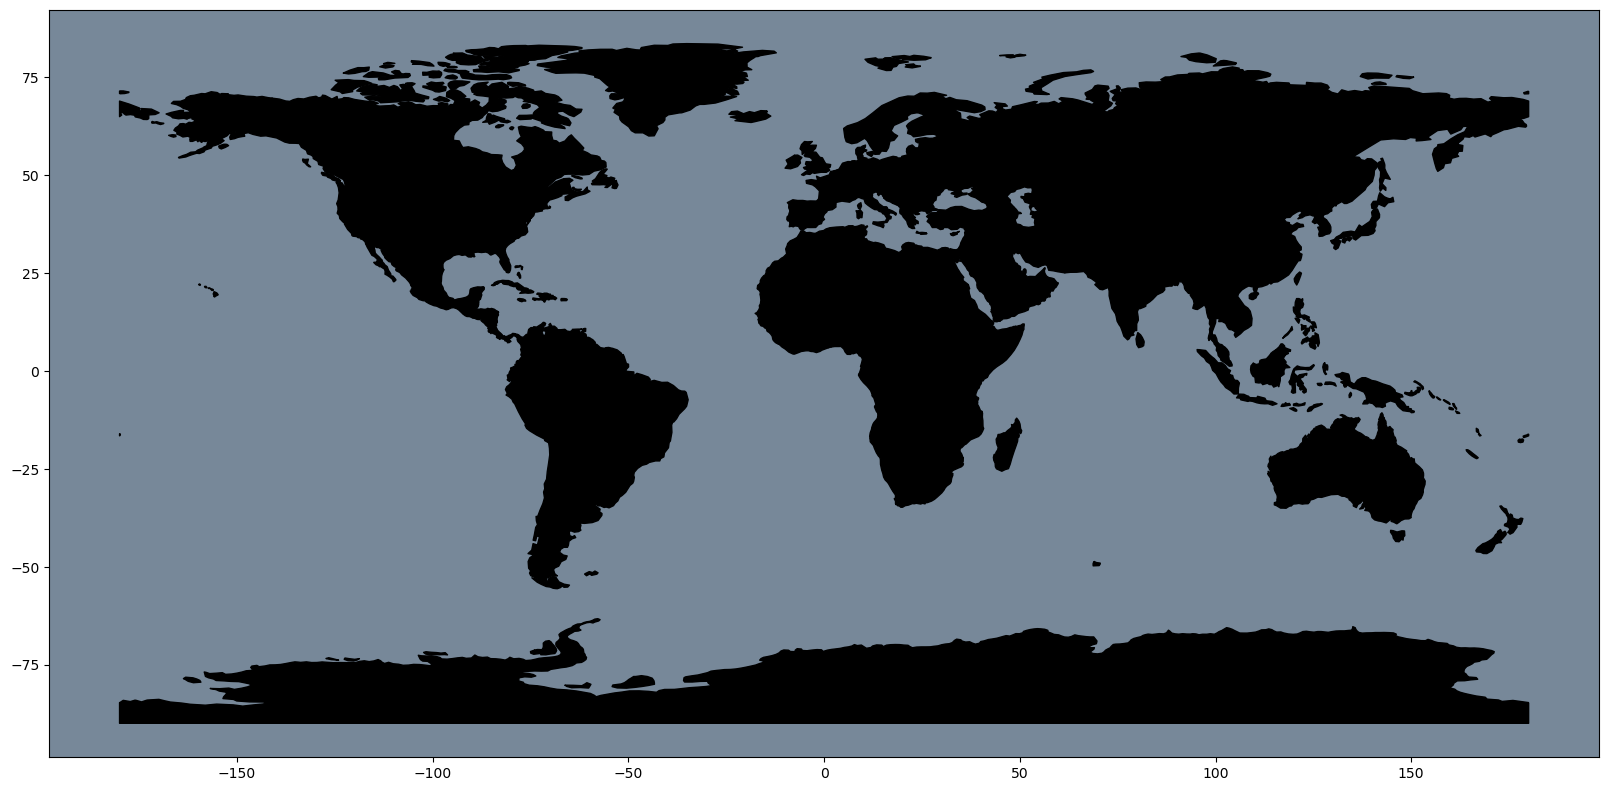

c:\Users\Best\anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



In [7]:
from jupyter_dash import JupyterDash
import pandas as pd
import sqlite3
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

def plot_spatial(ticker):
    conn = sqlite3.connect("stock.sqlite")
    query = "SELECT city,lat,long FROM stock_city WHERE `Ticker` = '%s'" % ticker
    address = pd.read_sql(query, conn)
    add = address.groupby(address.columns.tolist(),as_index=False).size()
    add.rename(columns={'size': 'population'}, inplace=True)
    df = add

    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
    gdf = GeoDataFrame(df, geometry=geometry)   
    gdf['Size'] = gdf['population'] * 40
    #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    base = world.plot(figsize=(20, 10),color='black', edgecolor='black')
    a = gdf.plot(ax=base, marker='o', column='population', cmap = 'Reds', markersize='Size',legend=True)
    a.set_facecolor("lightslategray")
    return a.figure

def plot_spatial(ticker):
    conn = sqlite3.connect("stock.sqlite")
    query = "SELECT city,lat,long FROM stock_city WHERE `Ticker` = '%s'" % ticker
    address = pd.read_sql(query, conn)
    add = address.groupby(address.columns.tolist(),as_index=False).size()
    add.rename(columns={'size': 'population'}, inplace=True)
    df = add

    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
    gdf = GeoDataFrame(df, geometry=geometry)   
    gdf['Size'] = gdf['population'] * 40
    #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    base = world.plot(figsize=(20, 10),color='black', edgecolor='black')
    a = gdf.plot(ax=base, marker='o', column='population', cmap = 'Reds', markersize='Size',legend=True)
    a.set_facecolor("lightslategray")

app.layout = html.Div(children=[
    html.Div([
        html.Div([
            "Stock : ",
            dcc.Input(id='ticker-input', value='', type='text'),
            html.Button(id='submit-button', n_clicks=0, children='Submit'),
        ],
            style={
                'margin-bottom': 20,
            }
        ),
        dcc.Dropdown(
            options=[
                {'label': 'Hour', 'value': 'Hour'},
                {'label': 'Day', 'value': 'Day'},
                {'label': 'Month', 'value': 'Month'}
            ],
            value='Hour',
            searchable=False,
            id='stock-dropdown',
            style={
                'margin-bottom': 20,
            }
        ),
        html.Div(id='output-div'),
        html.Div([
            html.Div(id="disp-ticker"),
            html.Div(id="disp-info")
        ])
    ],
        style={
            'margin-top': 50,
            'margin-right': 100,
            'margin-left': 100
        }
    ),
    html.Div([
        dcc.Graph(
            id='graph',
            figure=plot_spatial('')
        )],
        style={
            'margin-right': 20,
            'margin-left': 20
        }
    ),

    dcc.ConfirmDialog(
        id='popup',
        message='Not found that tickers',
        displayed=False,
    ),
    dcc.ConfirmDialog(
        id='popup_dl',
        message='Downloaded',
        displayed=False,
    ),
    dcc.ConfirmDialog(
        id='popup_fa',
        message='False to download for this ticker',
        displayed=False,
    ),
    html.Div(id='table-container-home'),
])


@app.callback(
    Output(component_id='graph', component_property='figure'),
    Input(component_id='submit-button', component_property='n_clicks'),
    Input(component_id='stock-dropdown', component_property='value'),
    Input(component_id='ticker-input', component_property='value')
)
def update_graph(n_clicks, stock_interval, ticker):
    fig = plot_spatial(ticker)
    return fig


if __name__ == '__main__':
    app.run_server(debug=True)


PyQT

In [1]:
import sys

from PyQt5.QtWebEngineWidgets import QWebEnginePage
from PyQt5.QtWidgets import QApplication
from PyQt5.QtCore import QUrl
from PyQt5.QtWebEngineWidgets import QWebEngineView

url = 'http://127.0.0.1:8050/'

app = QApplication(sys.argv)

# QWebEngineView
browser = QWebEngineView()
browser.load(QUrl(url))
browser.show()

sys.exit(app.exec_())

In [2]:
import sys

from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import QUrl
from PyQt5.QtWebEngineWidgets import QWebEnginePage, QWebEngineView
from PyQt5.QtWidgets import QApplication

url = 'http://127.0.0.1:8050/'


class Ui_MainWindow(object):
    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(1130, 781)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setObjectName("centralwidget")
        self.verticalLayoutWidget = QtWidgets.QWidget(self.centralwidget)
        self.verticalLayoutWidget.setGeometry(QtCore.QRect(0, 0, 241, 781))
        self.verticalLayoutWidget.setObjectName("verticalLayoutWidget")
        self.verticalLayout = QtWidgets.QVBoxLayout(self.verticalLayoutWidget)
        self.verticalLayout.setContentsMargins(0, 0, 0, 0)
        self.verticalLayout.setObjectName("verticalLayout")
        self.label = QtWidgets.QLabel(self.verticalLayoutWidget)
        self.label.setStyleSheet("font: 75 10pt \"MS Shell Dlg 2\";")
        self.label.setAlignment(QtCore.Qt.AlignCenter)
        self.label.setObjectName("label")
        self.verticalLayout.addWidget(self.label)
        self.pushButton_4 = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.pushButton_4.setEnabled(True)
        sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Fixed)
        sizePolicy.setHorizontalStretch(0)
        sizePolicy.setVerticalStretch(0)
        sizePolicy.setHeightForWidth(self.pushButton_4.sizePolicy().hasHeightForWidth())
        self.pushButton_4.setSizePolicy(sizePolicy)
        self.pushButton_4.setIconSize(QtCore.QSize(20, 20))
        self.pushButton_4.setObjectName("pushButton_4")
        self.verticalLayout.addWidget(self.pushButton_4)
        self.pushButton = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.pushButton.setObjectName("pushButton")
        self.verticalLayout.addWidget(self.pushButton)
        self.pushButton_2 = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.pushButton_2.setObjectName("pushButton_2")
        self.verticalLayout.addWidget(self.pushButton_2)
        self.pushButton_3 = QtWidgets.QPushButton(self.verticalLayoutWidget)
        self.pushButton_3.setObjectName("pushButton_3")
        self.verticalLayout.addWidget(self.pushButton_3)
        spacerItem = QtWidgets.QSpacerItem(20, 40, QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Expanding)
        self.verticalLayout.addItem(spacerItem)
        self.verticalLayout.setStretch(0, 2)
        self.verticalLayout.setStretch(1, 2)
        self.verticalLayout.setStretch(2, 2)
        self.verticalLayout.setStretch(3, 2)
        self.verticalLayout.setStretch(4, 2)
        self.verticalLayout.setStretch(5, 4)
        self.verticalLayoutWidget_2 = QtWidgets.QWidget(self.centralwidget)
        self.verticalLayoutWidget_2.setGeometry(QtCore.QRect(240, 0, 881, 781))
        self.verticalLayoutWidget_2.setObjectName("verticalLayoutWidget_2")
        self.verticalLayout_2 = QtWidgets.QVBoxLayout(self.verticalLayoutWidget_2)
        self.verticalLayout_2.setContentsMargins(0, 0, 0, 0)
        self.verticalLayout_2.setObjectName("verticalLayout_2")
        self.webView = QWebEngineView(self.verticalLayoutWidget_2)
        self.webView.setObjectName("webView")
        self.webView.load(QUrl(url))
        self.verticalLayout_2.addWidget(self.webView)
        MainWindow.setCentralWidget(self.centralwidget)

        self.retranslateUi(MainWindow)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)

    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "ML Stock"))
        self.label.setText(_translate("MainWindow", "ML STOCK RADAR"))
        self.pushButton_4.setText(_translate("MainWindow", "Dashboard"))
        self.pushButton.setText(_translate("MainWindow", "Graph"))
        self.pushButton_2.setText(_translate("MainWindow", "Financial"))
        self.pushButton_3.setText(_translate("MainWindow", "News"))


if __name__ == "__main__":
    import sys
    app = QtWidgets.QApplication(sys.argv)
    MainWindow = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(MainWindow)
    MainWindow.show()
    sys.exit(app.exec_())



127.0.0.1 - - [07/Mar/2023 23:18:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 23:18:38] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 23:18:38] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 23:18:38] "GET /_favicon.ico?v=2.7.1 HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 23:18:38] "POST /_dash-update-component HTTP/1.1" 500 -


SystemExit: 0

c:\Users\Best\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [30]:
# -*- coding: utf-8 -*-

# Form implementation generated from reading ui file 'ml_stock.ui'
#
# Created by: PyQt5 UI code generator 5.15.4
#
# WARNING: Any manual changes made to this file will be lost when pyuic5 is
# run again.  Do not edit this file unless you know what you are doing.

import sys

from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import QUrl
from PyQt5.QtWebEngineWidgets import QWebEnginePage, QWebEngineView
from PyQt5.QtWidgets import QApplication



url = 'http://127.0.0.1:8050'

class Ui_MainWindow(object):
        def setupUi(self, MainWindow):
                MainWindow.setObjectName("MainWindow")
                MainWindow.resize(1120, 780)
                MainWindow.setStyleSheet("background-color: rgb(10, 10, 28);")
                self.centralwidget = QtWidgets.QWidget(MainWindow)
                self.centralwidget.setObjectName("centralwidget")
                self.verticalLayoutWidget = QtWidgets.QWidget(self.centralwidget)
                self.verticalLayoutWidget.setGeometry(QtCore.QRect(0, 0, 241, 781))
                self.verticalLayoutWidget.setObjectName("verticalLayoutWidget")
                self.verticalLayout = QtWidgets.QVBoxLayout(self.verticalLayoutWidget)
                self.verticalLayout.setContentsMargins(0, 0, 0, 0)
                self.verticalLayout.setObjectName("verticalLayout")
                self.label = QtWidgets.QLabel(self.verticalLayoutWidget)
                self.label.setStyleSheet("font: 75 10pt \"MS Shell Dlg 2\";\n"
        "color: rgb(255, 255, 255);")
                self.label.setAlignment(QtCore.Qt.AlignCenter)
                self.label.setObjectName("label")
                self.verticalLayout.addWidget(self.label)
                self.pushButton_0 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_0.setEnabled(True)
                sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Fixed)
                sizePolicy.setHorizontalStretch(0)
                sizePolicy.setVerticalStretch(0)
                sizePolicy.setHeightForWidth(self.pushButton_0.sizePolicy().hasHeightForWidth())
                self.pushButton_0.setSizePolicy(sizePolicy)
                self.pushButton_0.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_0.setIconSize(QtCore.QSize(20, 20))
                self.pushButton_0.setObjectName("pushButton_0")
                self.verticalLayout.addWidget(self.pushButton_0)
                self.pushButton_1 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_1.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_1.setObjectName("pushButton_1")
                self.verticalLayout.addWidget(self.pushButton_1)
                self.pushButton_2 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_2.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_2.setObjectName("pushButton_2")
                self.verticalLayout.addWidget(self.pushButton_2)
                self.pushButton_3 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_3.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_3.setObjectName("pushButton_3")
                self.verticalLayout.addWidget(self.pushButton_3)
                spacerItem = QtWidgets.QSpacerItem(20, 40, QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Expanding)
                self.verticalLayout.addItem(spacerItem)
                self.verticalLayout.setStretch(0, 2)
                self.verticalLayout.setStretch(1, 2)
                self.verticalLayout.setStretch(2, 2)
                self.verticalLayout.setStretch(3, 2)
                self.verticalLayout.setStretch(4, 2)
                self.verticalLayout.setStretch(5, 4)
                self.verticalLayoutWidget_2 = QtWidgets.QWidget(self.centralwidget)
                self.verticalLayoutWidget_2.setGeometry(QtCore.QRect(240, 0, 881, 781))
                self.verticalLayoutWidget_2.setObjectName("verticalLayoutWidget_2")
                self.verticalLayout_2 = QtWidgets.QVBoxLayout(self.verticalLayoutWidget_2)
                self.verticalLayout_2.setContentsMargins(0, 0, 0, 0)
                self.verticalLayout_2.setObjectName("verticalLayout_2")
                self.stackedWidget = QtWidgets.QStackedWidget(self.verticalLayoutWidget_2)
                self.stackedWidget.setObjectName("stackedWidget")
                self.Dashboard = QtWidgets.QWidget()
                self.Dashboard.setObjectName("Dashboard")
                self.Dashboard.setStyleSheet("background-color: rgb(10, 10, 28);")

                self.webView1 = QWebEngineView(self.Dashboard)
                self.webView1.setGeometry(QtCore.QRect(0, 20, 861, 731))
                self.webView1.setObjectName("webView1")
                self.webView1.setUrl(QUrl(url+'//'))

                self.stackedWidget.addWidget(self.Dashboard)
                self.Graph = QtWidgets.QWidget()
                self.Graph.setObjectName("Graph")

                self.webView2 = QWebEngineView(self.Graph)
                self.webView2.setGeometry(QtCore.QRect(0, 20, 861, 731))
                self.webView2.setObjectName("webView2")
                self.webView2.setUrl(QUrl(url+'/graph'))

                self.stackedWidget.addWidget(self.Graph)
                self.Financial = QtWidgets.QWidget()
                self.Financial.setObjectName("Financial")

                self.webView3 = QWebEngineView(self.Financial)
                self.webView3.setGeometry(QtCore.QRect(0, 20, 861, 731))
                self.webView3.setObjectName("webView3")
                self.webView3.setUrl(QUrl(url+'/finance'))

                self.stackedWidget.addWidget(self.Financial)
                self.News = QtWidgets.QWidget()
                self.News.setObjectName("News")

                self.webView4 = QWebEngineView(self.News)
                self.webView4.setGeometry(QtCore.QRect(0, 20, 861, 731))
                self.webView4.setObjectName("webView4")
                self.webView4.setUrl(QUrl(url+'/news'))
                self.stackedWidget.addWidget(self.News)

                self.verticalLayout_2.addWidget(self.stackedWidget)
                MainWindow.setCentralWidget(self.centralwidget)

                self.pushButton_0.clicked.connect(self.dashboard_page)
                self.pushButton_1.clicked.connect(self.graph_page)
                self.pushButton_2.clicked.connect(self.financial_page)
                self.pushButton_3.clicked.connect(self.news_page)

                self.retranslateUi(MainWindow)
                self.stackedWidget.setCurrentIndex(0)
                QtCore.QMetaObject.connectSlotsByName(MainWindow)

        def dashboard_page(self):
                self.webView1.setUrl(QUrl(url+'//'))

        def graph_page(self):
                self.webView1.setUrl(QUrl(url+'/graph'))

        def financial_page(self):
                self.webView1.setUrl(QUrl(url+'/finance'))

        def news_page(self):
                self.webView1.setUrl(QUrl(url+'/news'))


        def retranslateUi(self, MainWindow):
                _translate = QtCore.QCoreApplication.translate
                MainWindow.setWindowTitle(_translate("MainWindow", "ML Stock"))
                self.label.setText(_translate("MainWindow", "ML STOCK RADAR"))
                self.pushButton_0.setText(_translate("MainWindow", "Dashboard"))
                self.pushButton_1.setText(_translate("MainWindow", "Graph"))
                self.pushButton_2.setText(_translate("MainWindow", "Financial"))
                self.pushButton_3.setText(_translate("MainWindow", "News"))


if __name__ == "__main__":
        import sys
        app = QtWidgets.QApplication(sys.argv)
        MainWindow = QtWidgets.QMainWindow()
        ui = Ui_MainWindow()
        ui.setupUi(MainWindow)
        MainWindow.show()
        sys.exit(app.exec_())


 ['AAV', 'ACE', 'ADVANC', 'AMATA', 'AOT', 'AP', 'AWC', 'BAM', 'BANPU', 'BBL', 'BCH', 'BCP', 'BCPG', 'BDMS', 'BEC', 'BEM', 'BGRIM', 'BH', 'BLA', 'BTS', 'BYD', 'CBG', 'CENTEL', 'CHG', 'CK', 'CKP', 'COM7', 'CPALL', 'CPF', 'CPN', 'CRC', 'DELTA', 'DOHOME', 'DTAC', 'EA', 'EGCO', 'EPG', 'ESSO', 'FORTH', 'GLOBAL', 'GPSC', 'GULF', 'GUNKUL', 'HANA', 'HMPRO', 'INTUCH', 'IRPC', 'IVL', 'JAS', 'JMART', 'JMT', 'KBANK', 'KCE', 'KEX', 'KKP', 'KTB', 'KTC', 'LH', 'MEGA', 'MINT', 'MTC', 'NEX', 'ONEE', 'OR', 'ORI', 'OSP', 'PLANB', 'PSL', 'PTG', 'PTT', 'PTTEP', 'PTTGC', 'QH', 'RATCH', 'RBF', 'RCL', 'SABUY', 'SAWAD', 'SCB', 'SCC', 'SCGP', 'SINGER', 'SPALI', 'SPRC', 'STA', 'STARK', 'STGT', 'TCAP', 'THANI', 'THG', 'TIDLOR', 'TIPH', 'TISCO', 'TOP', 'TQM', 'TRUE', 'TTB', 'TU', 'VGI', 'WHA']
 ['ABNB', 'ADBE', 'ADI', 'ADSK', 'AEP', 'ALGN', 'AMAT', 'AMGN', 'ANSS', 'ATVI', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CEG', 'CHTR', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DLTR', 'DXCM', 'EA', 'EBAY',

SystemExit: 0

c:\Users\Best\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [1]:
import sys

from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import QUrl
from PyQt5.QtWebEngineWidgets import QWebEnginePage, QWebEngineView
from PyQt5.QtWidgets import QApplication

url = 'http://127.0.0.1:8050'
class Ui_MainWindow(object):
        def setupUi(self, MainWindow):
                MainWindow.setObjectName("MainWindow")
                MainWindow.resize(1118, 779)
                MainWindow.setStyleSheet("background-color: rgb(10, 10, 28);")
                self.centralwidget = QtWidgets.QWidget(MainWindow)
                self.centralwidget.setObjectName("centralwidget")
                self.verticalLayoutWidget = QtWidgets.QWidget(self.centralwidget)
                self.verticalLayoutWidget.setGeometry(QtCore.QRect(0, 0, 241, 781))
                self.verticalLayoutWidget.setObjectName("verticalLayoutWidget")
                self.verticalLayout = QtWidgets.QVBoxLayout(self.verticalLayoutWidget)
                self.verticalLayout.setContentsMargins(0, 0, 0, 0)
                self.verticalLayout.setObjectName("verticalLayout")
                self.label = QtWidgets.QLabel(self.verticalLayoutWidget)
                self.label.setStyleSheet("font: 75 10pt \"MS Shell Dlg 2\";\n"
        "color: rgb(255, 255, 255);")
                self.label.setAlignment(QtCore.Qt.AlignCenter)
                self.label.setObjectName("label")
                self.verticalLayout.addWidget(self.label)
                self.pushButton_0 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_0.setEnabled(True)
                sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Fixed)
                sizePolicy.setHorizontalStretch(0)
                sizePolicy.setVerticalStretch(0)
                sizePolicy.setHeightForWidth(self.pushButton_0.sizePolicy().hasHeightForWidth())
                self.pushButton_0.setSizePolicy(sizePolicy)
                self.pushButton_0.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_0.setIconSize(QtCore.QSize(20, 20))
                self.pushButton_0.setObjectName("pushButton_0")
                self.verticalLayout.addWidget(self.pushButton_0)
                self.pushButton_1 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_1.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_1.setObjectName("pushButton_1")
                self.verticalLayout.addWidget(self.pushButton_1)
                self.pushButton_2 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_2.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_2.setObjectName("pushButton_2")
                self.verticalLayout.addWidget(self.pushButton_2)
                self.pushButton_3 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_3.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_3.setObjectName("pushButton_3")
                self.verticalLayout.addWidget(self.pushButton_3)
                self.pushButton_4 = QtWidgets.QPushButton(self.verticalLayoutWidget)
                self.pushButton_4.setStyleSheet("QPushButton {\n"
        "background-color: rgb(10, 10, 28);\n"
        "color: rgb(255, 255, 255);\n"
        "border-radius: 10px;\n"
        "height: 50px;\n"
        "font: 10pt \"MS Shell Dlg 2\";\n"
        "}\n"
        "\n"
        "QPushButton:pressed {\n"
        "    background-color: rgb(38, 38, 46);\n"
        "}")
                self.pushButton_4.setObjectName("pushButton_4")
                self.verticalLayout.addWidget(self.pushButton_4)
                spacerItem = QtWidgets.QSpacerItem(20, 40, QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Expanding)
                self.verticalLayout.addItem(spacerItem)
                self.verticalLayout.setStretch(0, 2)
                self.verticalLayout.setStretch(1, 2)
                self.verticalLayout.setStretch(2, 2)
                self.verticalLayout.setStretch(3, 2)
                self.verticalLayout.setStretch(4, 2)
                self.verticalLayout.setStretch(6, 4)
                self.verticalLayoutWidget_2 = QtWidgets.QWidget(self.centralwidget)
                self.verticalLayoutWidget_2.setGeometry(QtCore.QRect(240, 0, 881, 781))
                self.verticalLayoutWidget_2.setObjectName("verticalLayoutWidget_2")
                self.verticalLayout_2 = QtWidgets.QVBoxLayout(self.verticalLayoutWidget_2)
                self.verticalLayout_2.setContentsMargins(0, 0, 0, 0)
                self.verticalLayout_2.setObjectName("verticalLayout_2")
                self.frame = QtWidgets.QFrame(self.verticalLayoutWidget_2)
                self.frame.setFrameShape(QtWidgets.QFrame.StyledPanel)
                self.frame.setFrameShadow(QtWidgets.QFrame.Raised)
                self.frame.setObjectName("frame")
                self.webView = QWebEngineView(self.frame) 
                self.webView.setGeometry(QtCore.QRect(20, 20, 841, 731))
                self.webView.setObjectName("webView")
                self.webView.setUrl(QUrl(url+'//'))
                self.verticalLayout_2.addWidget(self.frame)
                MainWindow.setCentralWidget(self.centralwidget)

                self.pushButton_0.clicked.connect(self.dashboard_page)
                self.pushButton_1.clicked.connect(self.graph_page)
                self.pushButton_2.clicked.connect(self.financial_page)
                self.pushButton_3.clicked.connect(self.news_page)

                self.retranslateUi(MainWindow)
                QtCore.QMetaObject.connectSlotsByName(MainWindow)

        def dashboard_page(self):
                self.webView.setUrl(QUrl(url+'//'))

        def graph_page(self):
                self.webView.setUrl(QUrl(url+'/graph'))

        def financial_page(self):
                self.webView.setUrl(QUrl(url+'/finance'))

        def news_page(self):
                self.webView.setUrl(QUrl(url+'/news'))

        def retranslateUi(self, MainWindow):
                _translate = QtCore.QCoreApplication.translate
                MainWindow.setWindowTitle(_translate("MainWindow", "ML Stock"))
                self.label.setText(_translate("MainWindow", "ML STOCK RADAR"))
                self.pushButton_0.setText(_translate("MainWindow", "Dashboard"))
                self.pushButton_1.setText(_translate("MainWindow", "Graph"))
                self.pushButton_2.setText(_translate("MainWindow", "Financial"))
                self.pushButton_3.setText(_translate("MainWindow", "News"))
                self.pushButton_4.setText(_translate("MainWindow", "Location"))

if __name__ == "__main__":
        import sys
        app = QtWidgets.QApplication(sys.argv)
        MainWindow = QtWidgets.QMainWindow()
        ui = Ui_MainWindow()
        ui.setupUi(MainWindow)
        MainWindow.show()
        sys.exit(app.exec_())

SystemExit: 0

c:\Users\Best\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
from PyQt5 import QtCore, QtWidgets, QtWebEngineWidgets
import plotly.express as px


class Widget(QtWidgets.QWidget):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.button = QtWidgets.QPushButton('Plot', self)
        self.browser = QtWebEngineWidgets.QWebEngineView(self)

        vlayout = QtWidgets.QVBoxLayout(self)
        vlayout.addWidget(self.button, alignment=QtCore.Qt.AlignHCenter)
        vlayout.addWidget(self.browser)

        self.button.clicked.connect(self.show_graph)
        self.resize(1000,800)

    def show_graph(self):
        df = px.data.tips()
        fig = px.box(df, x="day", y="total_bill", color="smoker")
        fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
        self.browser.setHtml(fig.to_html(include_plotlyjs='cdn'))

if __name__ == "__main__":
    app = QtWidgets.QApplication([])
    widget = Widget()
    widget.show()
    app.exec()
    

In [53]:
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc, Input, Output, callback , State, ctx
import plotly.express as px
import pandas as pd

import numpy as np
import pandas as pd
import plotly
from plotly.subplots import make_subplots

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go
import sqlite3
import datetime


def getLastDate(period,ticker):
    conn = sqlite3.connect("stock.sqlite")
    cur = conn.cursor()
    # Query last element of stock in database
    if period == 'Hour':
        query = "SELECT * FROM stock_table_hr WHERE `ticker` = '%s'" % ticker
    elif period == 'Day':
        query = "SELECT * FROM stock_table_d WHERE `ticker` = '%s'" % ticker
    elif period == 'Mount':
        query = "SELECT * FROM stock_table_mo WHERE `ticker` = '%s'" % ticker
    else:
        return False
    r_df = pd.read_sql(query, conn)
    # Cut data to get only datatime
    last = r_df.tail(1).Datetime.to_string().split()
    LastDate = last[1].split()[0].split('-')
    cur.close()
    return LastDate,r_df

def getDiffDay(period,ticker):
    LastDate,r_df = getLastDate(period,ticker)
    if LastDate == False:
        return False
    # Get datetime for now
    x = datetime.datetime.now()
    count = 0
    DayM = 0
    DayMo365 = {'1':31,'2':28,'3':31,'4':30,'5':31,'6':30,'7':31,'8':31,'9':30,'10':31,'11':30,'12':31}
    DiffMo = int(x.month) - int(LastDate[1])
    DiffYe = int(x.year) - int(LastDate[0])
    # Get differend day for dowload stock
    if DiffYe == 0:
        if DiffMo == 0:
            DiffDay = int(x.day) - int(LastDate[2])
            if DiffDay != 0:pass
        elif DiffMo != 0 :
            for u in range(DiffMo):
                DayM = DayM + DayMo365[str(int(LastDate[1])+count)]
                count += 1
            DiffDay = DayM - int(LastDate[2]) + int(x.day)
    elif DiffYe != 0:
        dayly = 0
        dayn = 0
        for j in range(1,int(LastDate[1])):
            dayly = dayly + DayMo365[str(j)]
        for i in range(1,int(x.month)):
            dayn = dayn + DayMo365[str(i)]
        DiffDay = (365*DiffYe) - dayly + dayn - int(LastDate[2]) + int(x.day)   
    DiffDay = str(DiffDay) + 'd'
    return DiffDay
    
    
def update(period,ticker):
    LastDate,r_df = getLastDate(period,ticker)
    DiffDay = getDiffDay(period,ticker)
    if DiffDay == False:
        return False
    down = 0
    count = 0
    conn = sqlite3.connect("stock.sqlite")
    # Select period to download
    if period == 'Hour':data = yf.download(tickers=ticker, period=DiffDay, interval='1h')
    elif period == 'Day':data = yf.download(tickers=ticker, period=DiffDay, interval='1d')
    elif period == 'Mount':data = yf.download(tickers=ticker, period=DiffDay, interval='1mo')
    # Get number of extra stock
    for i in data.index.day:
        if data.index.year[count] == int(LastDate[0]):
            if data.index.month[count] == int(LastDate[1]):
                if i == int(LastDate[2])+1 or i == int(LastDate[2])+2 or i == int(LastDate[2])+3:
                    break
        count += 1
    ok = r_df.tail(1).Datetime.to_string().split()[2]
    if ok == '10:00:00':down = 5
    elif ok == '11:00:00':down = 4
    elif ok == '12:00:00':down = 3
    elif ok == '14:00:00':down = 2
    elif ok == '15:00:00':down = 1
    elif ok == '16:00:00':down = 0
    # Cut extra stock off
    count = count - down
    data['ticker'] = ticker
    data = data.iloc[count:,:]
    data.index.rename('Datetime', inplace=True)
    # Save to sqlite
    # Select period to download
    if period == 'Hour':data.to_sql('stock_table_hr',con=conn,if_exists='append',index=True)
    elif period == 'Day':data.to_sql('stock_table_d',con=conn,if_exists='append',index=True)
    elif period == 'Mount':data.to_sql('stock_table_mo',con=conn,if_exists='append',index=True)
    return data

# a = update('Hour','PTT.BK')
# print(a)
# print(a.index.month)
# getDiffDay('Hour','AOT.BK')
# b = getLastDate('Hour','AOT.BK')
# int(b[0][0])

[*********************100%***********************]  1 of 1 completed
                      Open   High    Low  Close  Adj Close    Volume  ticker
Datetime                                                                    
2023-01-09 10:00:00  32.75  33.00  32.75  33.00      33.00         0  PTT.BK
2023-01-09 11:00:00  33.00  33.00  32.75  32.75      32.75   2031247  PTT.BK
2023-01-09 12:00:00  33.00  33.00  32.75  33.00      33.00   2711964  PTT.BK
2023-01-09 14:00:00  33.00  33.00  32.75  32.75      32.75   2368997  PTT.BK
2023-01-09 15:00:00  33.00  33.25  32.75  33.00      33.00  17004500  PTT.BK
...                    ...    ...    ...    ...        ...       ...     ...
2023-01-24 11:00:00  33.75  33.75  33.50  33.75      33.75    630045  PTT.BK
2023-01-24 12:00:00  33.75  33.75  33.50  33.50      33.50    285526  PTT.BK
2023-01-24 14:00:00  33.50  33.75  33.50  33.50      33.50    880784  PTT.BK
2023-01-24 15:00:00  33.75  33.75  33.50  33.75      33.75   1658209  PTT.BK
2023-01

In [29]:
data = yf.download(tickers='PTT.BK', period='5mo', interval='1mo')
# data.index = data.index.split()
data

127.0.0.1 - - [07/Mar/2023 01:22:47] "GET /graph HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:47] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:47] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:48] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:48] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:48] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:22:49] "POST /_dash-update-component HTTP/1.1" 200 -


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

127.0.0.1 - - [07/Mar/2023 01:23:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:02] "POST /_dash-update-component HTTP/1.1" 500 -


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-01,36.00,36.25,32.75,33.25,32.522655,1339835100
2022-12-01,33.50,33.75,30.75,33.25,32.522655,1261207900
2023-01-01,33.00,34.00,32.00,33.25,32.522655,881176300
2023-02-01,33.25,33.50,31.75,31.75,31.055468,766657900
2023-03-01,32.00,32.50,31.25,31.50,31.500000,166293859


127.0.0.1 - - [07/Mar/2023 01:23:06] "GET /finance HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:06] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:06] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:06] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:06] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:39] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:39] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:23:40] "GET /_dash-component-suites/dash/dcc/async-dropdown.js H

[*********************100%***********************]  1 of 1 completed

127.0.0.1 - - [07/Mar/2023 01:23:47] "POST /_dash-update-component HTTP/1.1" 200 -



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, ticker]
Index: []


127.0.0.1 - - [07/Mar/2023 01:24:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:24:19] "POST /_dash-update-component HTTP/1.1" 200 -


[*********************100%***********************]  1 of 1 completed


127.0.0.1 - - [07/Mar/2023 01:24:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:24:21] "POST /_dash-update-component HTTP/1.1" 500 -


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, ticker]
Index: []
[*********************100%***********************]  1 of 1 completed

127.0.0.1 - - [07/Mar/2023 01:24:21] "POST /_dash-update-component HTTP/1.1" 500 -


127.0.0.1 - - [07/Mar/2023 01:24:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:35:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:35:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:35:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:39:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:39:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:40:08] "POST /_dash-update-component HTTP/1.1" 200 -


[*********************100%***********************]  1 of 1 completed
                     Open  High   Low  Close  Adj Close   Volume ticker
Datetime                                                               
2023-01-09 10:00:00  11.5  11.6  11.4   11.6       11.6        0  AP.BK
2023-01-09 11:00:00  11.5  11.6  11.4   11.5       11.5  2837240  AP.BK
2023-01-09 12:00:00  11.4  11.6  11.4   11.5       11.5  1320375  AP.BK
2023-01-09 14:00:00  11.5  11.6  11.4   11.5       11.5  9944270  AP.BK
2023-01-09 15:00:00  11.5  11.6  11.5   11.6       11.6  3937421  AP.BK
...                   ...   ...   ...    ...        ...      ...    ...
2023-03-03 11:00:00  12.3  12.3  12.2   12.2       12.2  1784687  AP.BK
2023-03-03 12:00:00  12.2  12.2  12.1   12.2       12.2  1968763  AP.BK
2023-03-03 14:00:00  12.1  12.3  12.1   12.2       12.2  2795458  AP.BK
2023-03-03 15:00:00  12.1  12.2  12.1   12.1       12.1   707403  AP.BK
2023-03-03 16:00:00  12.2  12.2  12.1   12.1       12.1  2806356  A

127.0.0.1 - - [07/Mar/2023 01:41:28] "POST /_dash-update-component HTTP/1.1" 500 -



            Open  High   Low  Close  Adj Close    Volume ticker
Datetime                                                       
2023-01-12  11.5  11.5  11.4   11.5       11.5   7396800  AP.BK
2023-01-13  11.6  11.6  11.3   11.4       11.4  10731300  AP.BK
2023-01-16  11.4  11.4  11.3   11.4       11.4   5080300  AP.BK
2023-01-17  11.4  11.5  11.3   11.3       11.3  12191900  AP.BK
2023-01-18  11.3  11.4  11.1   11.2       11.2  20899600  AP.BK
2023-01-19  11.3  11.4  11.2   11.4       11.4  10949700  AP.BK
2023-01-20  11.4  11.4  11.2   11.4       11.4  14315500  AP.BK
2023-01-23  11.4  11.5  11.3   11.4       11.4   9156300  AP.BK
2023-01-24  11.5  11.6  11.4   11.6       11.6  15377100  AP.BK
2023-01-25  11.6  11.6  11.4   11.5       11.5  11518900  AP.BK
2023-01-26  11.5  11.6  11.3   11.5       11.5  10507600  AP.BK
2023-01-27  11.5  11.7  11.4   11.6       11.6  14181800  AP.BK
2023-01-30  11.7  11.9  11.6   11.9       11.9  19517300  AP.BK
2023-01-31  12.0  12.1  11.8   11.9    

127.0.0.1 - - [07/Mar/2023 01:51:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:51:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2023 01:51:50] "POST /_dash-update-component HTTP/1.1" 200 -
